# Analyse de sentiment des clients des vols à partir des tweets

In [2]:
# Import some librairies
import numpy as np
import pandas as pd
import seaborn as sns
import re
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, Conv1D, Flatten, Dense, Dropout, Activation, MaxPooling1D, Normalization
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
#Source de la donnée
#https://www.kaggle.com/crowdflower/twitter-airline-sentiment?select=Tweets.csv

In [3]:
import io
from google.colab import files
uploaded = files.upload()

Saving Tweets.csv to Tweets.csv


In [4]:
raw_data = pd.read_csv(io.BytesIO(uploaded['Tweets.csv']))
raw_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
raw_data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [ ]:
# Drop unnecessary columns

In [7]:
raw_data = raw_data.drop(["name","tweet_id","tweet_coord"], axis=1)
raw_data = raw_data.rename(columns={"airline_sentiment":"label"})
raw_data.head()

,label,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,negativereason_gold,retweet_count,text,tweet_created,tweet_location,user_timezone
0,neutral,1.0000,NaN,NaN,Virgin America,NaN,NaN,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,positive,0.3486,NaN,0.0000,Virgin America,NaN,NaN,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,neutral,0.6837,NaN,NaN,Virgin America,NaN,NaN,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,NaN,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,NaN,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
# Combine to the tweets some information like, airline, negative reason, ...

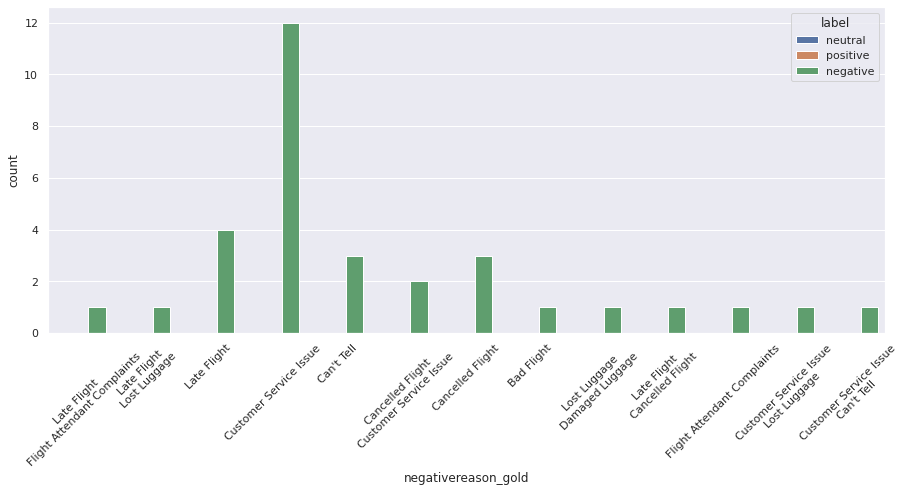

In [8]:
sns.set(rc = {'figure.figsize':(15,6)})
chart = sns.countplot(x="negativereason_gold", hue="label", data=raw_data)
_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

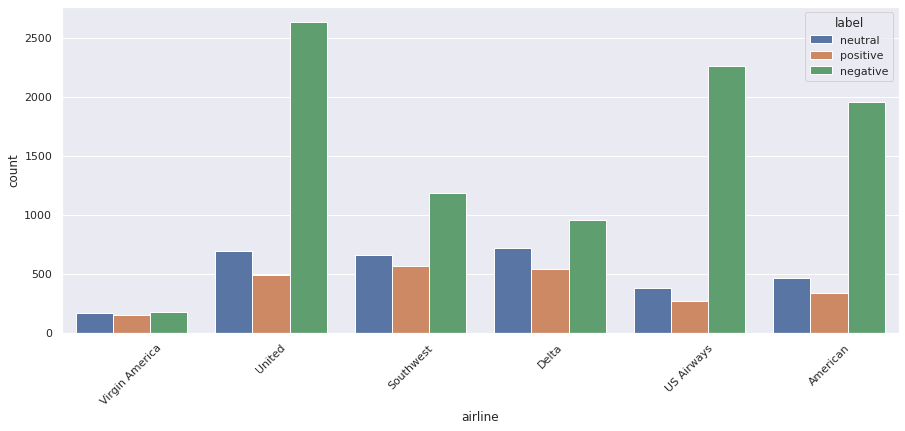

In [9]:
chart = sns.countplot(x="airline", hue="label", data=raw_data)
_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

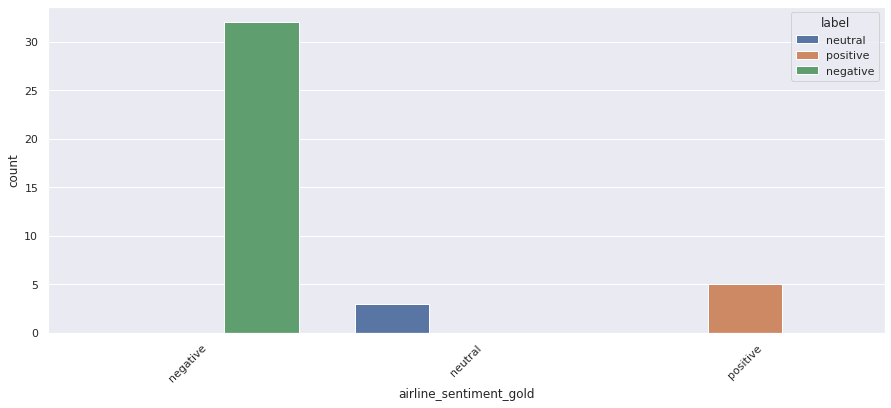

In [10]:
chart = sns.countplot(x="airline_sentiment_gold", hue="label", data=raw_data)
_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

In [11]:
#Fusion de columns textuelles
combined_columns = ["text","negativereason","airline","airline_sentiment_gold","negativereason_gold","tweet_location","user_timezone"]
raw_data["tweet_infos"] = raw_data[combined_columns].apply(lambda row: ' '.join([el for el in row if not pd.isnull(el)]), axis=1)
data = raw_data[["tweet_infos","airline_sentiment_confidence","negativereason_confidence","label"]]
data

,tweet_infos,airline_sentiment_confidence,negativereason_confidence,label
0,@VirginAmerica What @dhepburn said. Virgin Ame...,1.0000,NaN,neutral
1,@VirginAmerica plus you've added commercials t...,0.3486,0.0000,positive
2,@VirginAmerica I didn't today... Must mean I n...,0.6837,NaN,neutral
3,@VirginAmerica it's really aggressive to blast...,1.0000,0.7033,negative
4,@VirginAmerica and it's a really big bad thing...,1.0000,1.0000,negative
...,...,...,...,...
14635,@AmericanAir thank you we got on a different f...,0.3487,0.0000,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,1.0000,1.0000,negative
14637,@AmericanAir Please bring American Airlines to...,1.0000,NaN,neutral
14638,"@AmericanAir you have my money, you change my ...",1.0000,0.6659,negative


In [12]:
#Fill NAN values in negativereason_confidence with the mean of the non-null
non_null = [el for el in data["negativereason_confidence"].values if not pd.isnull(el)]
mean_value = np.mean(non_null)
data["negativereason_confidence"] = data["negativereason_confidence"].fillna(mean_value)
#Tranform categrical values for labels
labels_dic = {"negative": 0, "neutral": 1, "positive": 2}
data["label"] = data["label"].apply(lambda x: labels_dic[x])
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,tweet_infos,airline_sentiment_confidence,negativereason_confidence,label
0,@VirginAmerica What @dhepburn said. Virgin Ame...,1.0000,0.638298,1
1,@VirginAmerica plus you've added commercials t...,0.3486,0.000000,2
2,@VirginAmerica I didn't today... Must mean I n...,0.6837,0.638298,1
3,@VirginAmerica it's really aggressive to blast...,1.0000,0.703300,0
4,@VirginAmerica and it's a really big bad thing...,1.0000,1.000000,0
...,...,...,...,...
14635,@AmericanAir thank you we got on a different f...,0.3487,0.000000,2
14636,@AmericanAir leaving over 20 minutes Late Flig...,1.0000,1.000000,0
14637,@AmericanAir Please bring American Airlines to...,1.0000,0.638298,1
14638,"@AmericanAir you have my money, you change my ...",1.0000,0.665900,0


In [15]:
nltk.download('stopwords')
def clean_sentence(sentence):
    sentence = sentence.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    filtered_words = [w for w in tokens if not w in stopwords.words('english')]
    return " ".join(filtered_words)

data["tweet_infos"] = data["tweet_infos"].apply(lambda raw_text: clean_sentence(raw_text))
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tweet_infos,airline_sentiment_confidence,negativereason_confidence,label
0,virginamerica dhepburn said virgin america eas...,1.0000,0.638298,1
1,virginamerica plus added commercials experienc...,0.3486,0.000000,2
2,virginamerica today must mean need take anothe...,0.6837,0.638298,1
3,virginamerica really aggressive blast obnoxiou...,1.0000,0.703300,0
4,virginamerica really big bad thing tell virgin...,1.0000,1.000000,0
...,...,...,...,...
14635,americanair thank got different flight chicago...,0.3487,0.000000,2
14636,americanair leaving 20 minutes late flight war...,1.0000,1.000000,0
14637,americanair please bring american airlines bla...,1.0000,0.638298,1
14638,americanair money change flight answer phones ...,1.0000,0.665900,0


In [16]:
corpus_size = data.shape[0]
tokenizer = Tokenizer(corpus_size)
tokenizer.fit_on_texts(data["tweet_infos"].values)
sequences = tokenizer.texts_to_sequences(data["tweet_infos"].values)
tweet_num = pad_sequences(sequences, padding='post', truncating='post')
tweet_num = pd.DataFrame(tweet_num, columns=["col_"+str(i) for i in range(len(tweet_num[0]))])
#Combine numerical text to the initial dataset
data_final = pd.concat([tweet_num, data[["airline_sentiment_confidence","negativereason_confidence","label"]]], axis=1)
data_final

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_28,col_29,col_30,col_31,col_32,col_33,col_34,airline_sentiment_confidence,negativereason_confidence,label
0,55,7365,177,52,42,7,2,1,5,0,...,0,0,0,0,0,0,0,1.0000,0.638298,1
1,55,517,1192,2737,158,7366,52,42,24,2,...,0,0,0,0,0,0,0,0.3486,0.000000,2
2,55,67,751,538,49,119,116,154,52,42,...,0,0,0,0,0,0,0,0.6837,0.638298,1
3,55,92,4148,5205,5206,1017,3481,4149,36,402,...,0,0,0,0,0,0,0,1.0000,0.703300,0
4,55,92,418,32,449,22,52,42,24,2,...,0,0,0,0,0,0,0,1.0000,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,12,43,62,363,3,72,13,0,0,0,...,0,0,0,0,0,0,0,0.3487,0.000000,2
14636,12,416,275,109,18,3,4725,637,305,109,...,0,0,0,0,0,0,0,1.0000,1.000000,0
14637,12,47,631,13,201,13,5976,5975,0,0,...,0,0,0,0,0,0,0,1.0000,0.638298,1
14638,12,338,95,3,303,907,1556,97,2926,8,...,0,0,0,0,0,0,0,1.0000,0.665900,0


In [17]:
X = data_final.drop("label", axis=1)
X = np.array(X)
y = data_final["label"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
print("Train:",(len(X_train), len(y_train)))
print("Test:", (len(X_test), len(y_test)))


Train: (11712, 11712)
Test: (2928, 2928)


# Apply Models

## Neural Network (NN)

In [18]:
row_size = X.shape[0] #number of rows
column_size = X.shape[1] #number of columns
hidden_layer = 100 #number of neuron in hidden layer
output_layer = 3 #number of output neuron
model_1 = Sequential()
model_1.add(Dense(hidden_layer, input_shape=(column_size,)))
model_1.add(Dense(hidden_layer, activation='relu'))
model_1.add(Dense(hidden_layer, activation='relu'))
model_1.add(Dense(hidden_layer, activation='relu'))
model_1.add(Dense(output_layer, activation='softmax'))
model_1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3800      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 3)                 303       
                                                                 
Total params: 34,403
Trainable params: 34,403
Non-trainable params: 0
_________________________________________________________________


In [19]:
batch_size = 32
epochs = 10
history_1 = model_1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/10
366/366 [==============================] - 2s 4ms/step - loss: 36.1140 - accuracy: 0.4767 - val_loss: 12.7654 - val_accuracy: 0.4617
Epoch 2/10
366/366 [==============================] - 1s 3ms/step - loss: 7.4368 - accuracy: 0.4949 - val_loss: 5.4002 - val_accuracy: 0.3613
Epoch 3/10
366/366 [==============================] - 1s 3ms/step - loss: 3.3150 - accuracy: 0.5128 - val_loss: 2.1912 - val_accuracy: 0.5939
Epoch 4/10
366/366 [==============================] - 1s 3ms/step - loss: 1.9980 - accuracy: 0.5339 - val_loss: 1.9049 - val_accuracy: 0.4980
Epoch 5/10
366/366 [==============================] - 1s 3ms/step - loss: 1.5009 - accuracy: 0.5548 - val_loss: 1.4101 - val_accuracy: 0.5850
Epoch 6/10
366/366 [==============================] - 1s 3ms/step - loss: 1.2128 - accuracy: 0.5724 - val_loss: 1.2663 - val_accuracy: 0.6011
Epoch 7/10
366/366 [==============================] - 1s 3ms/step - loss: 1.1378 - accuracy: 0.5879 - val_loss: 1.0824 - val_accuracy: 0.6247
Epoc

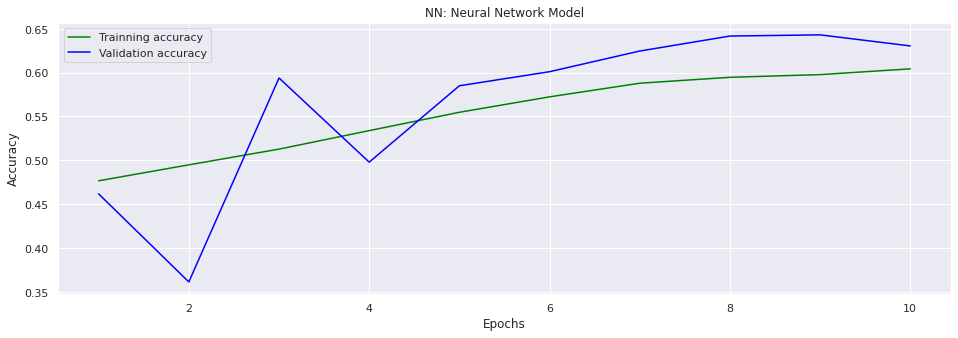

In [36]:
plt.figure(figsize=(16, 5))
epochs = range(1, len(history_1.history['accuracy'])+1)
plt.plot(epochs, history_1.history['accuracy'], 'b', label="Trainning accuracy", color='green')
plt.plot(epochs, history_1.history['val_accuracy'], 'b', label="Validation accuracy", color='blue')
plt.title("NN: Neural Network Model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## 2. LSTM : Long Short-Term Memory (RNN)

In [21]:
row_size = len(X) #number of rows
column_size = len(X[0]) #number of columns
hidden_layer = 100 #number of neuron in hidden layer
output_layer = 3 #number of output neuron

model_2 = Sequential()
model_2.add(Embedding(input_dim = row_size, output_dim = hidden_layer, input_length = column_size, trainable=True))
model_2.add(LSTM(hidden_layer, dropout=0.5, return_sequences=True))
model_2.add(LSTM(hidden_layer, dropout=0.5))
model_2.add(Dense(output_layer, activation='softmax'))
model_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 37, 100)           1464000   
                                                                 
 lstm (LSTM)                 (None, 37, 100)           80400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_5 (Dense)             (None, 3)                 303       
                                                                 
Total params: 1,625,103
Trainable params: 1,625,103
Non-trainable params: 0
_________________________________________________________________


In [22]:
batch_size = 32
epochs = 10
history_2 = model_2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/10
366/366 [==============================] - 39s 98ms/step - loss: 0.4859 - accuracy: 0.7807 - val_loss: 0.2806 - val_accuracy: 0.8484
Epoch 2/10
366/366 [==============================] - 35s 96ms/step - loss: 0.2353 - accuracy: 0.9065 - val_loss: 0.2048 - val_accuracy: 0.9245
Epoch 3/10
366/366 [==============================] - 35s 95ms/step - loss: 0.1556 - accuracy: 0.9471 - val_loss: 0.1859 - val_accuracy: 0.9296
Epoch 4/10
366/366 [==============================] - 35s 95ms/step - loss: 0.1267 - accuracy: 0.9583 - val_loss: 0.1902 - val_accuracy: 0.9296
Epoch 5/10
366/366 [==============================] - 35s 95ms/step - loss: 0.0949 - accuracy: 0.9682 - val_loss: 0.2281 - val_accuracy: 0.9197
Epoch 6/10
366/366 [==============================] - 35s 95ms/step - loss: 0.0784 - accuracy: 0.9758 - val_loss: 0.2394 - val_accuracy: 0.9255
Epoch 7/10
366/366 [==============================] - 35s 95ms/step - loss: 0.0634 - accuracy: 0.9797 - val_loss: 0.2399 - val_accuracy:

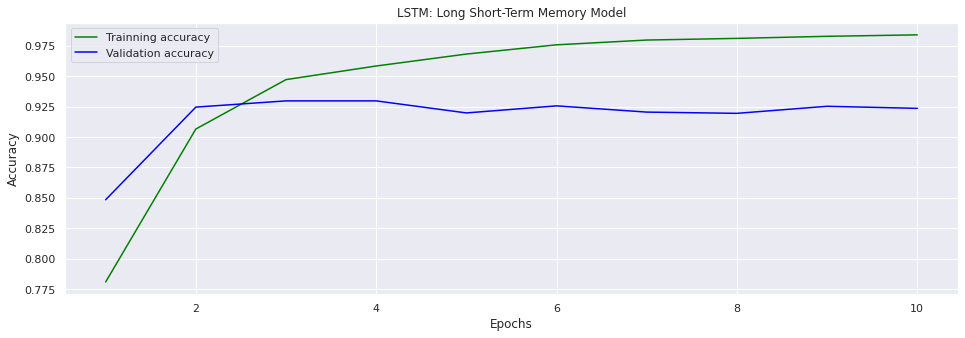

In [23]:
plt.figure(figsize=(16, 5))
epochs = range(1, len(history_2.history['accuracy'])+1)
plt.plot(epochs, history_2.history['accuracy'], 'b', label="Trainning accuracy", color='green')
plt.plot(epochs, history_2.history['val_accuracy'], 'b', label="Validation accuracy", color='blue')
plt.title("LSTM: Long Short-Term Memory Model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## 3. Convolutional Neural Network (CNN)

In [24]:
row_size = len(X) #number of rows
column_size = len(X[0]) #number of columns
nb_filters = 16
kernel_size = 3
hidden_layer = 100 #number of neuron in hidden layer
output_layer = 3 #number of output neuron

model_3 = Sequential()
#Embedding
model_3.add(Embedding(row_size, hidden_layer, input_length = column_size))

#Convolution
model_3.add(Dropout(0.5))
model_3.add(Conv1D(nb_filters, kernel_size, padding='valid', activation='relu'))
model_3.add(MaxPooling1D())
model_3.add(Conv1D(nb_filters, kernel_size, padding='valid', activation='relu'))
model_3.add(MaxPooling1D())
model_3.add(Flatten())

#Learning
model_3.add(Dense(hidden_layer, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(output_layer, activation='softmax'))
model_3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 37, 100)           1464000   
                                                                 
 dropout (Dropout)           (None, 37, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 35, 16)            4816      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 17, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 16)            784       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 16)            0         
 1D)                                                  

In [25]:
batch_size = 32
epochs = 10
history_3 = model_3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/10
366/366 [==============================] - 10s 26ms/step - loss: 0.4780 - accuracy: 0.7627 - val_loss: 0.2761 - val_accuracy: 0.8381
Epoch 2/10
366/366 [==============================] - 10s 26ms/step - loss: 0.2858 - accuracy: 0.8289 - val_loss: 0.2517 - val_accuracy: 0.8480
Epoch 3/10
366/366 [==============================] - 10s 26ms/step - loss: 0.2153 - accuracy: 0.9006 - val_loss: 0.1981 - val_accuracy: 0.9204
Epoch 4/10
366/366 [==============================] - 10s 26ms/step - loss: 0.1147 - accuracy: 0.9584 - val_loss: 0.1916 - val_accuracy: 0.9245
Epoch 5/10
366/366 [==============================] - 9s 26ms/step - loss: 0.0719 - accuracy: 0.9775 - val_loss: 0.2025 - val_accuracy: 0.9211
Epoch 6/10
366/366 [==============================] - 10s 26ms/step - loss: 0.0514 - accuracy: 0.9834 - val_loss: 0.2496 - val_accuracy: 0.9143
Epoch 7/10
366/366 [==============================] - 10s 26ms/step - loss: 0.0359 - accuracy: 0.9891 - val_loss: 0.2386 - val_accuracy: 

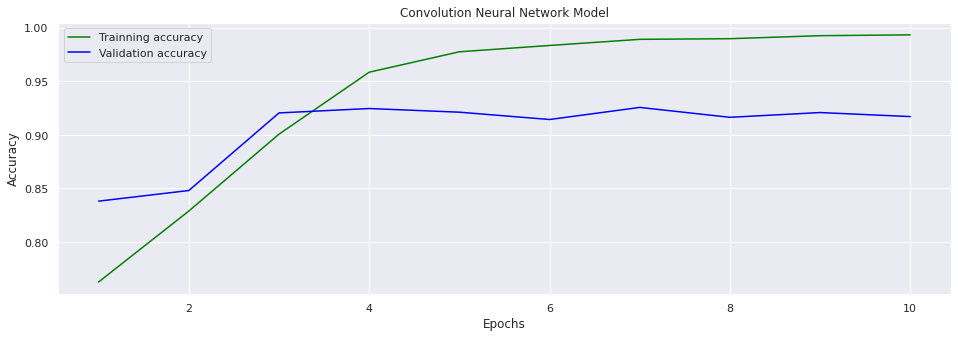

In [26]:
plt.figure(figsize=(16, 5))
epochs = range(1, len(history_3.history['accuracy'])+1)
plt.plot(epochs, history_3.history['accuracy'], 'b', label="Trainning accuracy", color='green')
plt.plot(epochs, history_3.history['val_accuracy'], 'b', label="Validation accuracy", color='blue')
plt.title("Convolution Neural Network Model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## 4. Gated Recurrent Units (GRU)

In [33]:

model_4 = Sequential()
model_4.add(Embedding(input_dim = row_size, output_dim = hidden_layer, input_length = column_size, trainable=True))
model_4.add(GRU(hidden_layer, dropout=0.5))
model_4.add(Dense(output_layer, activation='softmax'))
model_4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_4.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 37, 100)           1464000   
                                                                 
 gru_3 (GRU)                 (None, 100)               60600     
                                                                 
 dense_12 (Dense)            (None, 3)                 303       
                                                                 
Total params: 1,524,903
Trainable params: 1,524,903
Non-trainable params: 0
_________________________________________________________________


In [34]:
batch_size = 32
epochs = 10
history_4 = model_4.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/10
366/366 [==============================] - 25s 61ms/step - loss: 0.8031 - accuracy: 0.6173 - val_loss: 0.7722 - val_accuracy: 0.6134
Epoch 2/10
366/366 [==============================] - 25s 68ms/step - loss: 0.7836 - accuracy: 0.6214 - val_loss: 0.7737 - val_accuracy: 0.6144
Epoch 3/10
366/366 [==============================] - 19s 52ms/step - loss: 0.4518 - accuracy: 0.7655 - val_loss: 0.2604 - val_accuracy: 0.8391
Epoch 4/10
366/366 [==============================] - 19s 52ms/step - loss: 0.2707 - accuracy: 0.8356 - val_loss: 0.2634 - val_accuracy: 0.8405
Epoch 5/10
366/366 [==============================] - 19s 52ms/step - loss: 0.2219 - accuracy: 0.8889 - val_loss: 0.1790 - val_accuracy: 0.9293
Epoch 6/10
366/366 [==============================] - 19s 51ms/step - loss: 0.1124 - accuracy: 0.9569 - val_loss: 0.1931 - val_accuracy: 0.9194
Epoch 7/10
366/366 [==============================] - 18s 50ms/step - loss: 0.0753 - accuracy: 0.9740 - val_loss: 0.2130 - val_accuracy:

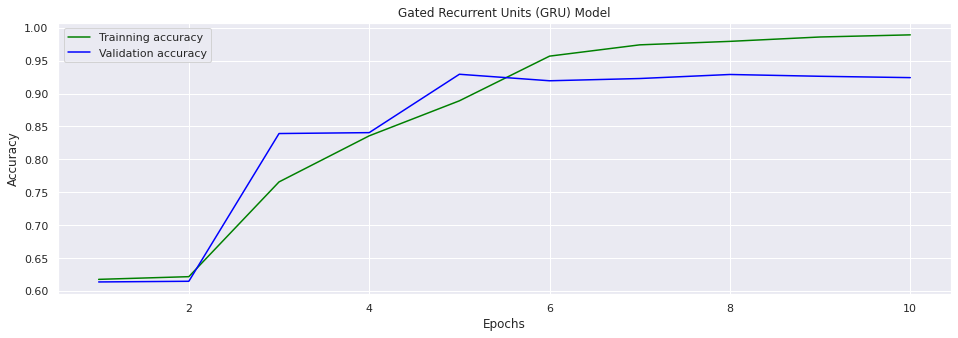

In [35]:
plt.figure(figsize=(16, 5))
epochs = range(1, len(history_4.history['accuracy'])+1)
plt.plot(epochs, history_4.history['accuracy'], 'b', label="Trainning accuracy", color='green')
plt.plot(epochs, history_4.history['val_accuracy'], 'b', label="Validation accuracy", color='blue')
plt.title("Gated Recurrent Units (GRU) Model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()